# Denoising diffusion: 2D Swiss roll

Generative modeling with DDPMs is demonstrated on the basis of a toy example. A 2D version of the good old Swiss roll data set is used to train a simple denoising diffusion model. The example merely serves the purpose of quickly familiarizing with the algorithm and its properties. Most of the model architecture or hyperparameter choices are quite arbitrary.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl

from diffusion import (
    DDPM,
    ConditionalDenseModel,
    make_beta_schedule
)

## Swiss roll data

Synthetic training and validation sets are generated in the following, totalling $N=2000$ samples $\{\boldsymbol{x}_{0,i}\}_{i=1}^N$. They are created with function `make_swiss_roll` from scikit-learn. The data are restricted to two dimensions and scaled. Any further normalization will be omitted.

In [3]:
num_samples = 2000
noise_level = 0.5

X, _ = make_swiss_roll(num_samples, noise=noise_level)
X = X[:,[0,2]] / 10 # restrict to 2D and scale

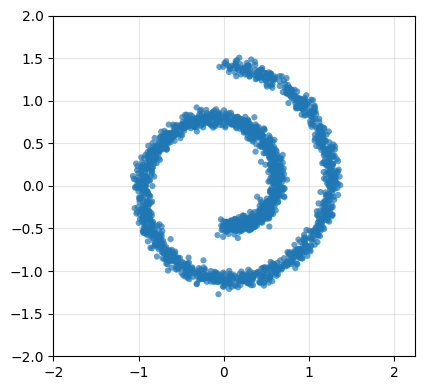

In [4]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(X[:,0], X[:,1], s=20, alpha=0.7, edgecolors='none')
ax.set(xlim=(-2, 2.25), ylim=(-2, 2))
ax.set_aspect('equal', adjustable='box')
ax.grid(visible=True, which='both', color='gray', alpha=0.2, linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()

After the data have been generated, PyTorch `TensorDataset`s and `DataLoader`s are constructed. They allow for assembling and accessing mini-batches of data during training.

In [5]:
X_train, X_val = train_test_split(X, test_size=0.2)

X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()

train_set = TensorDataset(X_train)
val_set = TensorDataset(X_val)

print('No. train images:', len(train_set))
print('No. val. images:', len(val_set))

No. train images: 1600
No. val. images: 400


In [6]:
batch_size = 64

train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          drop_last=True,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True)

val_loader = DataLoader(val_set,
                        batch_size=batch_size,
                        drop_last=False,
                        shuffle=False,
                        num_workers=4,
                        pin_memory=True)

print('No. train batches:', len(train_loader))
print('No. val. batches:', len(val_loader))

No. train batches: 25
No. val. batches: 7


## DDPM


An instance of `ConditionalDenseModel` is employed as the model $\boldsymbol{\epsilon}_\boldsymbol{\theta}(\boldsymbol{x}_t, t)$. It is composed of a number of fully connected layers and ReLU activation functions. Every layer is explicitly conditioned on the time $t$.

In [7]:
num_features = [2, 128, 128, 128, 2]

eps_model = ConditionalDenseModel(num_features, activation='relu', embed_dim=50)

Our diffusion process consists of $T=1000$ time steps. Note that, very probably, one could get away with a much smaller number. The corresponding $\beta$-schedule, which represents an important setting, is created with `make_beta_schedule`. A `DDPM`-object is initialized, providing methods for the forward and reverse process. Moreover, it allows for computing the simplified stochastic optimization objective.

In [8]:
# betas = make_beta_schedule(num_steps=1000, mode='quadratic', beta_range=(1e-04, 0.02))
# betas = make_beta_schedule(num_steps=1000, mode='cosine', cosine_s=0.008)
betas = make_beta_schedule(num_steps=1000, mode='sigmoid', sigmoid_range=(-5, 5))

ddpm = DDPM(eps_model=eps_model, betas=betas, criterion='mse')

The values $\beta_t$ and $\bar{\alpha}_t$ corresponding to the selected schedule are plotted below for all $t=1,\ldots,1000$.

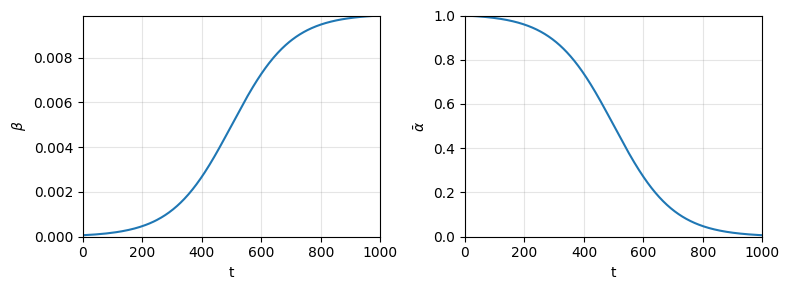

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

ax1.plot(np.arange(len(ddpm.betas)) + 1, ddpm.betas)
ax1.set(xlim=(0, len(ddpm.betas)), ylim=(0, ddpm.betas.max()))
ax1.set(xlabel='t', ylabel='$\\beta$')
ax1.grid(visible=True, which='both', color='gray', alpha=0.2, linestyle='-')
ax1.set_axisbelow(True)

ax2.plot(np.arange(len(ddpm.alphas_bar)) + 1, ddpm.alphas_bar)
ax2.set(xlim=(0, len(ddpm.alphas_bar)), ylim=(0, 1))
ax2.set(xlabel='t', ylabel='$\\bar{\\alpha}$')
ax2.grid(visible=True, which='both', color='gray', alpha=0.2, linestyle='-')
ax2.set_axisbelow(True)

fig.tight_layout()

## Forward process simulation

It is interesting to visualize the forward diffusion process applied to the problem at hand. To that end, the training data are diffused step by step according to $q(\boldsymbol{x}_t | \boldsymbol{x}_{t-1}) = \mathcal{N}(\boldsymbol{x}_t | \sqrt{1-\beta_t} \boldsymbol{x}_{t-1}, \beta_t \boldsymbol{I})$ with the method `diffuse_all_steps`. Intermediate results for certain time steps can then be plotted. This allows us to observe the advancing diffusion process from data to pure noise "in action".

In [10]:
x_noisy = ddpm.diffuse_all_steps(X_train)

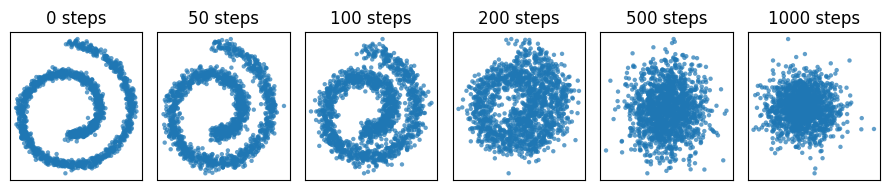

In [11]:
plot_steps = [0, 50, 100, 200, 500, 1000]

fig, axes = plt.subplots(nrows=1, ncols=len(plot_steps), figsize=(9, 2))
for time_idx, ax in zip(plot_steps, axes.ravel()):
    samples = x_noisy[time_idx].numpy()
    ax.scatter(samples[:,0], samples[:,1], s=10, alpha=0.7, edgecolors='none')
    ax.set_title('{} steps'.format(time_idx))
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
fig.tight_layout()

It is noted that the simulation of $q(\boldsymbol{x}_t | \boldsymbol{x}_0) = \mathcal{N}(\boldsymbol{x}_t | \sqrt{\bar{\alpha}_t} \boldsymbol{x}_0, (1-\bar{\alpha}_t) \boldsymbol{I})$ at any time step directly is enabled by the method `diffuse`.

## Reverse process training

We are eventually all set for training the model specified above. The loss $L_\text{simple} = \mathbb{E}_{\mathcal{U}(t|1, T), q(\boldsymbol{x}_0), \mathcal{N}(\boldsymbol{\epsilon} | \boldsymbol{0}, \boldsymbol{I})}[\lVert \boldsymbol{\epsilon} - \boldsymbol{\epsilon}_\boldsymbol{\theta}(\sqrt{\bar{\alpha}_t} \boldsymbol{x}_0 + \sqrt{1-\bar{\alpha_t}} \boldsymbol{\epsilon}, t) \rVert^2]$ has to be minimized for that purpose. This is accomplished with PyTorch Lightning, a library conveniently performing training, logging and checkpointing.

In [12]:
logger = pl.loggers.CSVLogger('.', name='lightning_logs', version=0)

trainer = pl.Trainer(logger=logger,
                     max_epochs=1000,
                     log_every_n_steps=len(train_loader),
                     enable_progress_bar=False)

trainer.validate(ddpm, dataloaders=val_loader, verbose=False) # check validation loss before training
trainer.fit(ddpm, train_dataloaders=train_loader, val_dataloaders=val_loader) # start training

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type                  | Params
----------------------------------------------------
0 | eps_model | ConditionalDenseModel | 53.4 K
1 | criterion | MSELoss               | 0     
----------------------------------------------------
53.4 K    Trainable params
0         Non-trainable params
53.4 K    Total params
0.213     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=1000` reached.


Note the extreme noise in the train and validation curves below. In addition to the inevitably imperfect and noisy convergence behavior, and the mini-batched evaluation of the training loss, the stochastic loss function here contributes to the overall noise.

In [13]:
metrics_df = pd.read_csv('lightning_logs/version_0/metrics.csv')

train_df = metrics_df[['step', 'train_loss']].dropna()
val_df = metrics_df[['step', 'val_loss']].dropna()

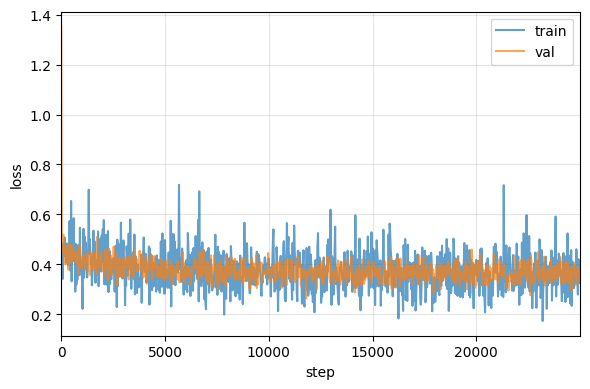

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(train_df['step'], train_df['train_loss'], alpha=0.7, label='train')
ax.plot(val_df['step'], val_df['val_loss'], alpha=0.7, label='val')
ax.set(xlabel='step', ylabel='loss')
ax.set_xlim([0, max(train_df['step'].max(), val_df['step'].max())])
ax.legend()
ax.grid(visible=True, which='both', color='gray', alpha=0.2, linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()

## Generation

After having trained the model, the denoising process can be used for data generation. The `denoise_all_steps` method allows one to perform $p_\boldsymbol{\theta}(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t) = \mathcal{N}(\boldsymbol{x}_{t-1} | \boldsymbol{\mu}_\boldsymbol{\theta}(\boldsymbol{x}_t, t), \sigma_t^2 \boldsymbol{I})$ with $\boldsymbol{\mu}_\boldsymbol{\theta}(\boldsymbol{x}_t, t) = \frac{1}{\sqrt{\alpha_t}}(\boldsymbol{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_\boldsymbol{\theta}(\boldsymbol{x}_t, t))$ in step-wise fashion. This way, the progressive generation can be visualized for intermediate steps. The evolution from pure noise into the targeted spiral-shaped structure can be observed.

In [15]:
ddpm.eval()
x_denoise = ddpm.denoise_all_steps(torch.randn(1000, 2))

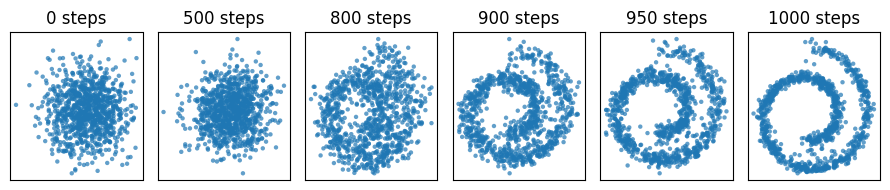

In [16]:
plot_steps_reverse = [ddpm.num_steps - s for s in reversed(plot_steps)]

fig, axes = plt.subplots(nrows=1, ncols=len(plot_steps_reverse), figsize=(9, 2))
for time_idx, ax in zip(plot_steps_reverse, axes.ravel()):
    samples = x_denoise[time_idx].numpy()
    ax.scatter(samples[:,0], samples[:,1], s=10, alpha=0.7, edgecolors='none')
    ax.set_title('{} steps'.format(time_idx))
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
fig.tight_layout()

The same process is also implemented by `generate`, without storing intermediate results though. We use this method to generate some final samples.

In [17]:
x_gen = ddpm.generate(sample_shape=(2,), num_samples=1000)

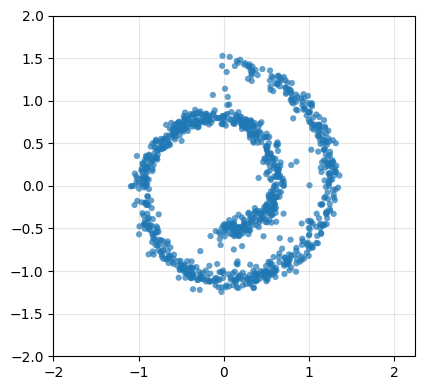

In [18]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(x_gen[:,0], x_gen[:,1], s=20, alpha=0.7, edgecolors='none')
ax.set(xlim=(-2, 2.25), ylim=(-2, 2))
ax.set_aspect('equal', adjustable='box')
ax.grid(visible=True, which='both', color='gray', alpha=0.2, linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()

Well, it seems to work!